# Primera parte: Arbol desicion para clasificar estrellas

### contexto
En astronomía, la clasificación estelar es la clasificación de las estrellas basada en sus características espectrales. El esquema de clasificación de galaxias, cuásares y estrellas es uno de los más fundamentales de la astronomía. La temprana catalogación de las estrellas y su distribución en el cielo ha permitido comprender que componen nuestra propia galaxia y, tras la distinción de que Andrómeda era una galaxia separada de la nuestra, se empezaron a estudiar numerosas galaxias a medida que se construían telescopios más potentes. El objetivo de este datasat es clasificar las estrellas, galaxias y cuásares en función de sus características espectrales.

En este problema, usaremos el algoritmo de árbol de decisión para clasificar estrellas según sus características numéricas. La explicación de los datos del CSV es la siguiente:

- obj_ID: Identificador de Objeto, el valor único que identifica el objeto en el catálogo de imágenes usado por el CAS.
- alpha: Ángulo de Ascensión Recta (en la época J2000).
- delta: Ángulo de Declinación (en la época J2000).
- u: Filtro ultravioleta en el sistema fotométrico.
- g: Filtro verde en el sistema fotométrico.
- r: Filtro rojo en el sistema fotométrico.
- i: Filtro de infrarrojo cercano en el sistema fotométrico.
- z: Filtro de infrarrojo en el sistema fotométrico.
- run_ID: Número de ejecución usado para identificar el escaneo específico.
- rereun_ID: Número de reejecución para especificar cómo se procesó la imagen.
- cam_col: Columna de la cámara para identificar la línea de escaneo dentro de la ejecución.
- field_ID: Número de campo para identificar cada campo.
- spec_obj_ID: ID único usado para objetos espectroscópicos ópticos (esto significa que 2 observaciones diferentes con el mismo spec_obj_ID deben compartir la clase de salida).
- class: Clase de objeto (galaxia, estrella o objeto cuásar).
- redshift: Valor de desplazamiento al rojo basado en el aumento de longitud de onda.
- plate: ID de placa, identifica cada placa en el SDSS.
- MJD: Fecha Juliana Modificada, usada para indicar cuándo se tomó un dato específico del SDSS.
- fiber_ID: ID de fibra que identifica la fibra que apuntó la luz en el plano focal en cada observación.


### Limpiar datos:

Hay que tener en considreacion que hay datos que no aportan datos importantes al algoritmo de entrenamiento. Estas fueron las columnas descartas para nuestro analisis:

- obj_ID: Descartada porque es solo un ID del objeto.
- run_ID: Descartada porque es un numero de ejecucion del escaneo.
- rereun_ID: Descartada porque es un numero de ejecucion del re-escaneo.
- cam_col: Descartada porque es un numero para identificar la lina de escane de la ejecucion. 
- field_ID: Descartada porque es un numero para identificar cada campo.
- spec_obj_ID: Descartada porque es ID único usado para objetos espectroscópicos ópticos
- plate: Descartada porque es un ID de placa
- MJD: Descartada porque es la fecha Juliana Modificada
- fiber_ID: Descartada porque es un ID de fibra que identifica la fibra que apuntó la luz en el plano focal en cada observación

En resumen, fueron descartados porque son ID's o fechas.

# Cambios realizdos en el dataset: 
	
Se necesito hacer cambios en el CSV. La columna **class** fue cambiada a los siguientes valores:

1. Galaxy = 0
2. QSO = 1
3. STAR = 2

Esto fue necesario poque la libreria **sklearn.tree** no acepta valores tipo string para los valores de la columna target.

# Cargar datos

In [1]:
import pandas as pd

col_names = ["obj_ID","alpha","delta","u","g","r","i","z","run_ID","rerun_ID","cam_col","field_ID","spec_obj_ID","class","redshift","plate","MJD","fiber_ID"] # Columas del CSV. Tuve que colocar todas porque sino, pandas no me leia bien los datos del CSV.

stars = pd.read_csv("data/star_classification.csv", header = 0, names = col_names) # leer el CSV

feature_cols = ["alpha", "delta", "u", "g", "r", "i", "z", "redshift"] # Columnas a utilizar para el analisis

# Analisis PCA

### Analisis antes de normalizar los datos:

Como en la pagina que proporciona este dataset no proporciona informacion sobre las escalas que se ocuparon para medir estos datos, primero voy a ver si es ncesario escalar los datos.

Variance percentage per component
[3.77979831e-01 2.83620624e-01 1.42618386e-01 1.07690353e-01
 8.34813766e-02 4.44135581e-03 1.38318700e-04 2.97538599e-05]


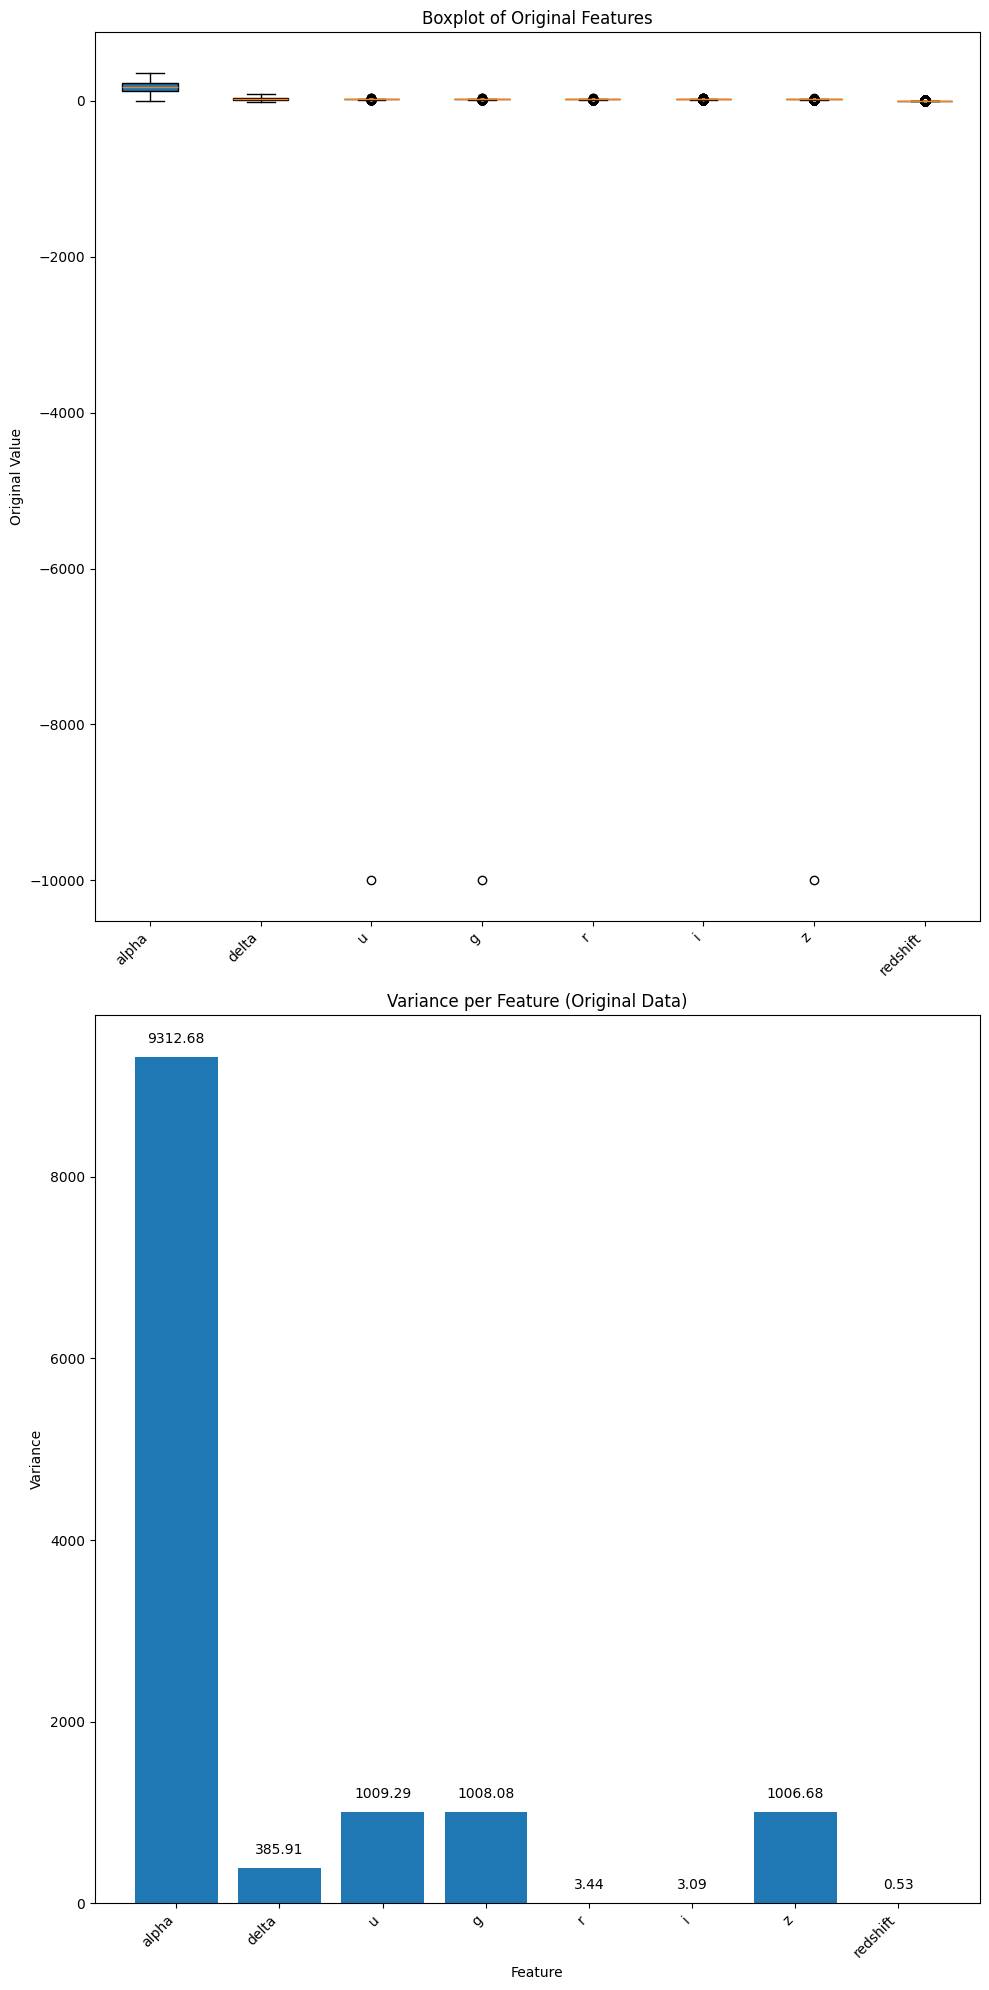

In [2]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Assuming stars is a DataFrame and feature_cols is a list of column names
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(stars[feature_cols])

# Extract the trained PCA object from the pipeline
pca_trained = pca_pipe.named_steps["pca"]

# Print the variance percentage per component
print("Variance percentage per component")
print(pca_trained.explained_variance_ratio_)

# Create the figure and axes
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 20))

# Boxplot for the original data
axs[0].boxplot(stars[feature_cols], patch_artist=True)
axs[0].set_xticks(np.arange(1, len(feature_cols) + 1))
axs[0].set_xticklabels(feature_cols, rotation=45, ha='right')
axs[0].set_title("Boxplot of Original Features")
axs[0].set_ylabel("Original Value")

# Bar plot for the original data (variance per feature)
original_variances = stars[feature_cols].var()
axs[1].bar(
    x=np.arange(len(feature_cols)) + 1,
    height=original_variances
)

for x, y in zip(np.arange(len(feature_cols)) + 1, original_variances):
    label = round(y, 2)
    axs[1].annotate(
        label,
        (x, y),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center'
    )

axs[1].set_xticks(np.arange(len(feature_cols)) + 1)
axs[1].set_xticklabels(feature_cols, rotation=45, ha='right')
axs[1].set_title("Variance per Feature (Original Data)")
axs[1].set_xlabel("Feature")
axs[1].set_ylabel("Variance")

# Standardize the original data
scaled_data = StandardScaler().fit_transform(stars[feature_cols])


plt.tight_layout()
plt.show()


### Observaciones:

Queda claro que los datos deben ser normalizados para un mejor analisis ya que alpha tiene una gran varianza. 

El boxplot no se puede observar con claridad dado que hay datos atipicos que hacen que los datos dentro de la normalidad se ven muy pquenhos. Pero de todas formas procederemos a hacer ;a estandarizacion.

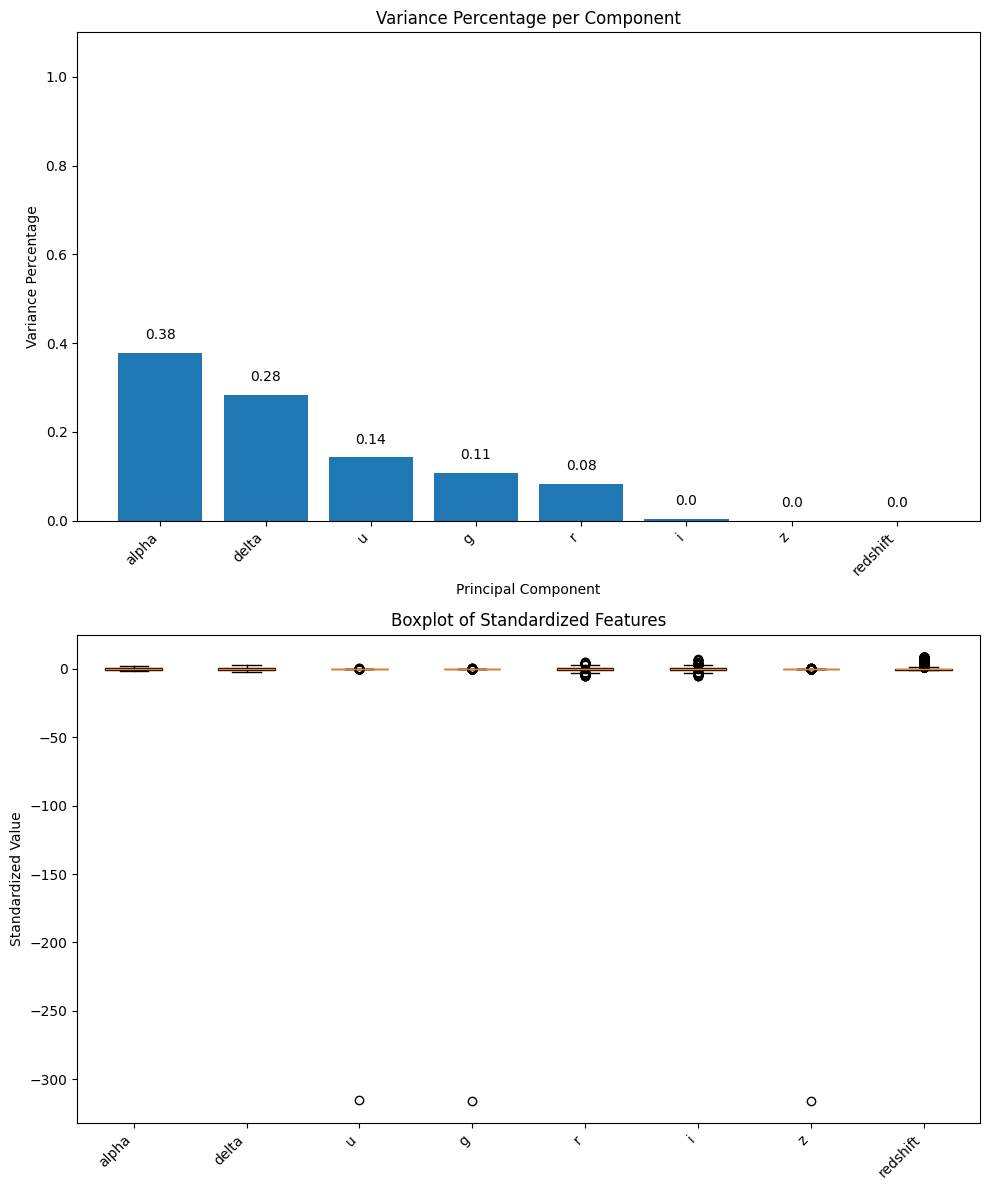

In [3]:
# Create the figure and axes
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

# Bar plot for variance percentage per component
axs[0].bar(
    x=np.arange(pca_trained.n_components_) + 1,
    height=pca_trained.explained_variance_ratio_
)

for x, y in zip(np.arange(len(stars.columns)) + 1, pca_trained.explained_variance_ratio_):
    label = round(y, 2)
    axs[0].annotate(
        label,
        (x, y),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center'
    )

axs[0].set_xticks(np.arange(pca_trained.n_components_) + 1)
axs[0].set_xticklabels(feature_cols, rotation=45, ha='right')
axs[0].set_ylim(0, 1.1)
axs[0].set_title("Variance Percentage per Component")
axs[0].set_xlabel("Principal Component")
axs[0].set_ylabel("Variance Percentage")

# Standardize the original data
scaled_data = StandardScaler().fit_transform(stars[feature_cols])

# Boxplot for the standardized data
axs[1].boxplot(scaled_data, patch_artist=True)
axs[1].set_xticks(np.arange(1, len(feature_cols) + 1))
axs[1].set_xticklabels(feature_cols, rotation=45, ha='right')
axs[1].set_title("Boxplot of Standardized Features")
axs[1].set_ylabel("Standardized Value")

plt.tight_layout()
plt.show()

### Analisis de los datos

Las categorías "alpha" y "delta" explican el 0.38% y 0.28% de la varianza respectivamente, significa que estas dos componentes capturan una parte considerable de la estructura de los datos, aunque los porcentajes son relativamente bajos en términos absolutos.

El hecho de que la varianza explicada por "alpha" y "delta" sea baja sugiere que los datos tienen una alta dimensionalidad y que ninguna de las componentes principales individuales explica una gran cantidad de la varianza.

Las categorias "r", "i", "z", "redshift" poseen un porcentaje de varianza baja, lo que sugiere una alta dimensionalidad y que los datos son similares entre si.

Usaremos los datos normalizados para entrenar el modelo. Esto por dos motivos principales:

1) Kneighbours es muy sensible a los datos, especialmente si no estan normalizdos y existe una gran varianza(como este caso). Por esto, es importante normalizar los datos para hacer una comparacion justa.

2) Se supone que Random forest es un algorimto mas robusto en cuanto a la sensibilidad de los datos, ya que segun la documentacion, este algoritmo no se comporta tan mal si los datos no estan normalizados. Aprovecharemos de ver si esto es verdad incluso si los datos estan normalizados.

# Normalizar datos

In [4]:
from sklearn.model_selection import train_test_split
# Normalize dataset
preprocessing_pipe = make_pipeline(StandardScaler())
x, y  = stars[feature_cols], stars["class"] # Separar los datos

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

preprocessing_pipe.fit(x_train)
x_normalized = preprocessing_pipe.transform(x_train)


### Caracteristicas

In [5]:
x_train

,alpha,delta,u,g,r,i,z,redshift
76513,130.932167,4.313411,20.13070,18.37146,17.49792,17.06977,16.77949,0.155863
60406,225.429599,33.172083,19.86315,18.93886,18.59344,18.46922,18.40977,-0.000529
27322,219.173525,55.511740,19.84785,17.60157,16.71511,16.41555,16.25413,-0.000261
53699,178.735461,36.044139,17.83635,16.47576,15.82407,15.45751,15.18434,0.068444
65412,192.807458,18.727770,24.27039,22.60266,20.47710,19.45898,19.08250,0.540778
...,...,...,...,...,...,...,...,...
6265,242.605987,36.722746,20.82854,20.32382,20.25718,20.39426,20.36549,2.412806
54886,171.747491,53.692339,18.93209,16.96611,16.05940,15.64639,15.30356,0.081128
76820,156.991726,38.612456,23.95684,21.37612,19.75149,18.49137,17.77083,0.000253
860,55.829432,9.764397,17.79224,16.47265,15.84970,15.59104,15.46414,0.000000


### Target

In [6]:
y_train

76513    0
60406    2
27322    2
53699    0
65412    0
        ..
6265     1
54886    0
76820    2
860      0
15795    0
Name: class, Length: 70000, dtype: int64

# Entrenar el algoritmo Desiciontree Classifier

In [7]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier() # Create object to train the model
dt.fit(x_normalized, y_train) # Train the classifier

dt_predictions = dt.predict(x_normalized) # Hacer predicciones

In [8]:
# Predicciones
dt_predictions

array([0, 2, 2, ..., 2, 0, 0])

# Vizualizar el modelo

PD: Descomentar las lineas si gusta. Las dejamos comentadas porque es un arbol enorme que se demora mucho en cargar

In [9]:
from sklearn.tree import plot_tree

class_names = ["GALAXY", "QSO", "STAR"]

#plt.figure(figsize=(20,10))
#plot_tree(clf, filled = True, feature_names = feature_cols, class_names = class_names, rounded = True)
#plt.show()

# Entrenar KNeighborsClassifier

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_normalized, y_train)

knn_predictions = knn.predict(x_normalized)


# Entrenar KNeighborsClassifier con datos sin normalizar

In [11]:
from sklearn.neighbors import KNeighborsClassifier

knn_dnn = KNeighborsClassifier()
knn_dnn.fit(x,y)

knn_predictions_dnn = knn_dnn.predict(x)

# Entrenar RandomForest

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_normalized, y_train)

rf_predictions = rf.predict(x_normalized)

# Metricas de evaluacion

### Confusion matrix

Text(0.5, 1.0, 'KNN not normalzed data Confusion Matrix')

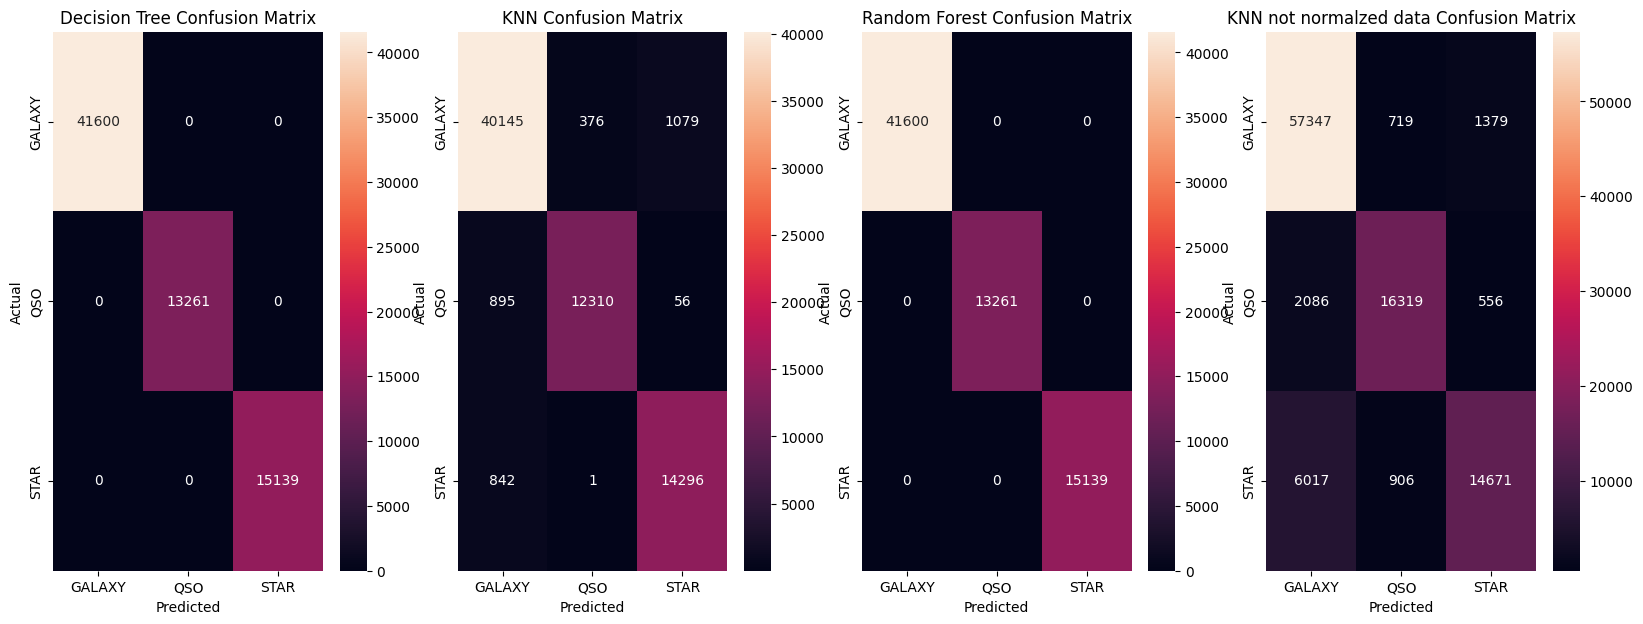

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ["GALAXY", "QSO", "STAR"]

fig, ax = plt.subplots(1, 4, figsize=(20, 7))

cm_dt = confusion_matrix(y_train, dt_predictions)
cm_knn = confusion_matrix(y_train, knn_predictions)
cm_rf = confusion_matrix(y_train, rf_predictions)
cm_knn_dnn = confusion_matrix(y, knn_predictions_dnn)

sns.heatmap(cm_dt, annot=True, fmt='d', ax=ax[0], xticklabels=class_names, yticklabels=class_names)
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
ax[0].set_title('Decision Tree Confusion Matrix')

sns.heatmap(cm_knn, annot=True, fmt='d', ax=ax[1], xticklabels=class_names, yticklabels=class_names)
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
ax[1].set_title('KNN Confusion Matrix')

sns.heatmap(cm_rf, annot=True, fmt='d', ax=ax[2], xticklabels=class_names, yticklabels=class_names)
ax[2].set_xlabel('Predicted')
ax[2].set_ylabel('Actual')
ax[2].set_title('Random Forest Confusion Matrix')

sns.heatmap(cm_knn_dnn, annot=True, fmt='d', ax=ax[3], xticklabels=class_names, yticklabels=class_names)
ax[3].set_xlabel('Predicted')
ax[3].set_ylabel('Actual')
ax[3].set_title('KNN not normalzed data Confusion Matrix')

### Accuracy, recall y f1 score

### Desicion tree

In [ ]:

from sklearn.metrics import f1_score, accuracy_score, recall_score

dt_accuracy, dt_f1, dt_recall = accuracy_score(y_train, dt_predictions), f1_score(y_train, dt_predictions, average=None), recall_score(y_train, dt_predictions, average=None)
print("Accuracy:", dt_accuracy)
print(f'Recall: {dt_f1}')
print("Recall: ", dt_recall )

Accuracy: 1.0
Recall: [1. 1. 1.]
Recall:  [1. 1. 1.]


### K nearest neighbors

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, recall_score

knn_accuracy, knn_f1, knn_recall = accuracy_score(y_train, knn_predictions), f1_score(y_train, knn_predictions, average=None), recall_score(y_train, knn_predictions, average=None)
print("Accuracy:", knn_accuracy)
print(f'Recall: {knn_f1}')
print("Recall: ", knn_recall )

Accuracy: 0.9535857142857143
Recall: [0.96176421 0.94882072 0.93529604]
Recall:  [0.96502404 0.92828595 0.94431601]


### K nearest neighbors con data no normalizada

In [16]:
from sklearn.metrics import f1_score, accuracy_score, recall_score

knn_dnn_accuracy, knn_dnn_f1, knn_dnn_recall = accuracy_score(y, knn_predictions_dnn), f1_score(y, knn_predictions_dnn, average=None), recall_score(y, knn_predictions_dnn, average=None)
print("Accuracy:", knn_dnn_accuracy)
print(f'Recall: {knn_dnn_f1}')
print("Recall: ", knn_dnn_recall )

Accuracy: 0.88337
Recall: [0.91832339 0.88437881 0.76811518]
Recall:  [0.96470687 0.86066136 0.67940169]


### Random forest

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, recall_score

rf_accuracy, rf_f1, rf_recall = accuracy_score(y_train, rf_predictions), f1_score(y_train, rf_predictions, average=None), recall_score(y_train, rf_predictions, average=None)
print("Accuracy:", rf_accuracy)
print(f'Recall: {rf_f1}')
print("Recall: ", rf_recall )

Accuracy: 0.9999857142857143
Recall: [0.99998798 0.99996229 1.        ]
Recall:  [1.         0.99992459 1.        ]


# Analisis de resultados:

I) Decision tree y random forest fueron los algoritmos que mejor se comportaron. Cabe mencionar que este resultado solo fue conseguido al ejecutar random forest con 100 estimators, porque con ~50 de estos, el algoritmo no obtuvo buenos resultados. Entendemos que random forest genera un resultado a partir del promedio de los reultados de multiples arboles y que al haber mas de estos se reduce la varianza y se genera un mejor resultado, pero aun asi, habiendo normalizado los datos, pensabamos que conseguiria un mejor resultado con menos estimators.

II) KNN fue el algoritmo que peor rendimiento tuvo. Leyendo la documentacion, pensabamos que al normalizar los datos y reducir la varianza, este algoritmo tendria un mejor rendimiento, pero no fue asi. Es por esto que decidimos explorar su resultado al no normalizar los datos, pero obtuvo un rendimiento peor. Aunque tampoco es que su rendimiento fuera pesimo, las metricas dan unos buenos resultados. Solo que al lado de decsision tree y random forest, este genera un peor resultado.

III) En cuanto a tiempo de ejecucion, claramente gana decision tree. Puede que esto no sea importante para esta instancia, pero nos llamo la atencion lo poco que se demora en entrenar este algoritmo en comparacion a knn y randomforest, los cuales se demoraron 5 y 20 veces mas en entrenar

En conclusion, dado su bajo tiempo de entramiento, su baja sensibilidad datos no normalizados, a sus buenos resultados, en resumen, eficiencia, nuestro algoritmo preferido es decision tree.